### Imports

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Reshape
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import to_categorical, plot_model

#### Load & clean data

In [2]:
genomes = pd.read_csv('final_viral_genomes.csv')

genomes.rename(columns = {'Genome': 'Name'}, inplace = True)

genomes.info()

In [5]:
# Clean up the length column and convert the values to ints
genomes['Length'] = genomes['Length'].apply(lambda x: int(x.replace('nt', '').replace('(', '').replace(')','')))

In [6]:
# Clean up the Phylogeny column a little bit
genomes['Phylogeny'] = genomes['Phylogeny'].apply(lambda x: x[9:-1] if x[-1] == ';' else x[9:])
genomes['Phylogeny'] = genomes['Phylogeny'].apply(lambda x: x.split(';')[1:] if len(x.split(';')) > 1 
                                                  else x.split(';'))
genomes['Phylogeny'] = genomes['Phylogeny'].apply(lambda x: ','.join(x))

genomes.tail()

In [8]:
# Clean up the SequenceType string, I just want every complete genome to have the same label so I can pick them out
def clean_sequence_type(string):
    string = str(string) 
                           
    if string == 'complete genome' or string == 'complete sequence' or 'complete genome' in string or 'complete sequence' in string or string == 'complate genome':
        return('complete genome')
    else:
        return(string)


genomes['SequenceType'] = genomes['SequenceType'].apply(clean_sequence_type)
genomes['SequenceType'].value_counts()

In [10]:
# Check the different host values
genomes['Host'].value_counts()

bacteria                             2213
invertebrates                        2082
plants                               1965
vertebrates                          1318
vertebrates, human                    547
vertebrates, invertebrates, human     305
fungi                                 269
invertebrates, plants                 192
environment                           173
vertebrates, invertebrates            149
archaea                                89
algae                                  64
protozoa                               58
invertebrates, vertebrates, human       7
invertebrates, vertebrates              7
human                                   7
None                                    4
eukaryotes                              4
diatom                                  3
protozoa, vertebrates                   1
Name: Host, dtype: int64

In [11]:
# Turn the number of proteins into an int
genomes['Protein'] = genomes['Protein'].apply(lambda x: int(x) if x.isdigit() else np.nan)

# Exploratory Data Analysis

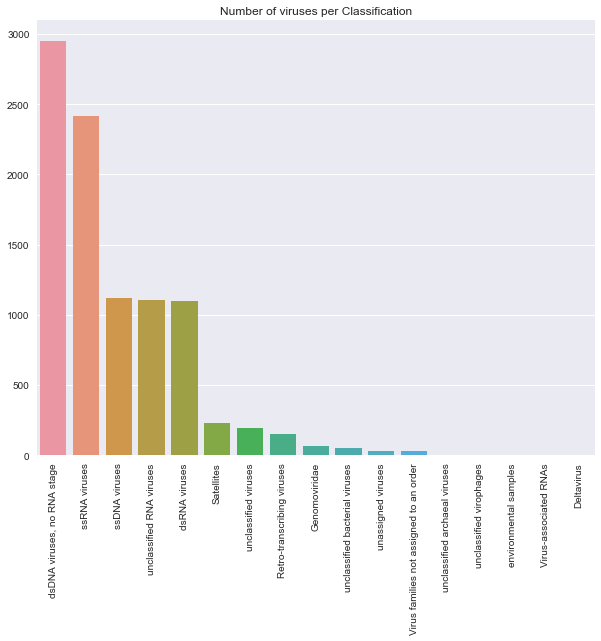

In [12]:
# Turn classifications and their counts into lists
classifications = [item[0] for item in list(genomes['Classification'].value_counts().items())]
class_counts = [item[1] for item in list(genomes['Classification'].value_counts().items())]

# Plot classifications and counts
plt.figure(figsize = (10,8))
virus_count_bar = sns.barplot(classifications, class_counts)
# Rotate x-axis ticklabels to make them legible
for item in virus_count_bar.get_xticklabels():
    item.set_rotation(90)
plt.title('Number of viruses per Classification')
# Don't print the matplotlib plot text output
None

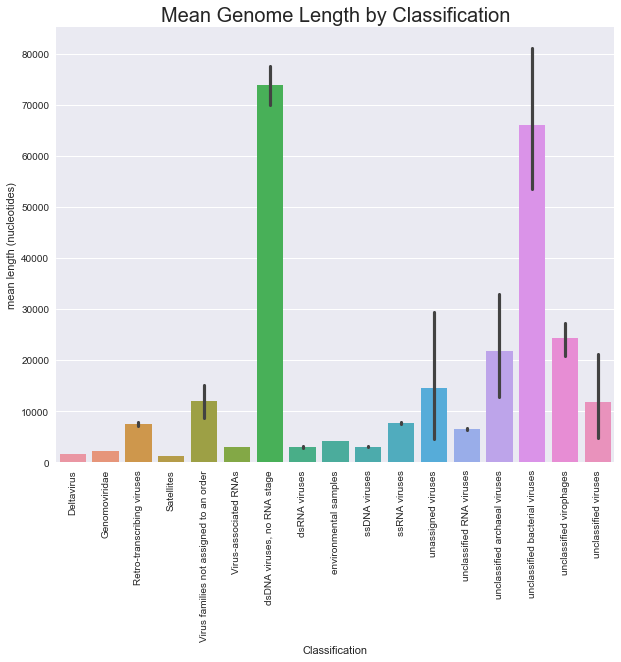

In [13]:
# Plot the mean genome length (and error bars) for each classification
plt.figure(figsize = (10,8))
class_length_bar = sns.barplot(genomes['Classification'], genomes['Length'])
for item in class_length_bar.get_xticklabels():
    item.set_rotation(90)
plt.title('Mean Genome Length by Classification', fontsize=20)
plt.ylabel('mean length (nucleotides)')
None

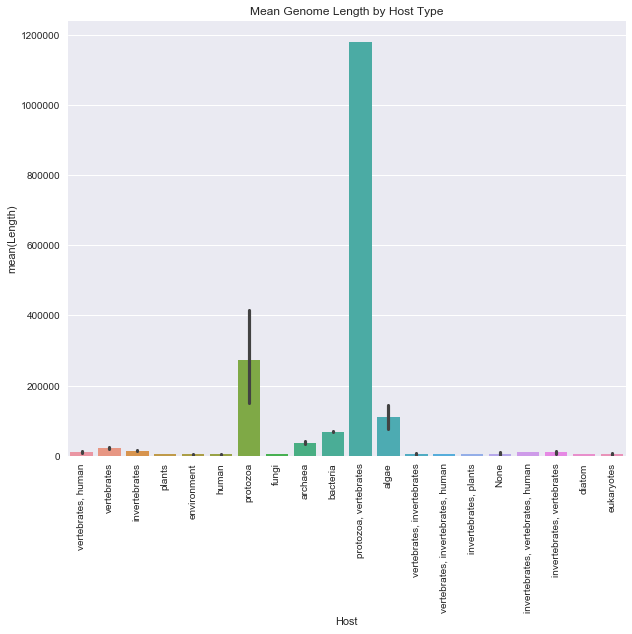

In [14]:
# Plot the mean genome length for each host type
plt.figure(figsize = (10,8))
type_length_bar = sns.barplot(genomes['Host'], genomes['Length'])
for item in type_length_bar.get_xticklabels():
    item.set_rotation(90)
plt.title('Mean Genome Length by Host Type')
None

In [15]:
classifications

['dsDNA viruses, no RNA stage',
 'ssRNA viruses',
 'ssDNA viruses',
 'unclassified RNA viruses',
 'dsRNA viruses',
 'Satellites',
 'unclassified viruses',
 'Retro-transcribing viruses',
 'Genomoviridae',
 'unclassified bacterial viruses',
 'unassigned viruses',
 'Virus families not assigned to an order',
 'unclassified archaeal viruses',
 'unclassified virophages',
 'environmental samples',
 'Virus-associated RNAs',
 'Deltavirus']

Number per Phylogeny in unclassified RNA viruses 
 ['unclassified RNA viruses'] : [1105] 

Number per Phylogeny in unclassified viruses 
 ['unclassified viruses'] : [195] 

Number per Phylogeny in Retro-transcribing viruses 
 ['Retro'] : [151] 

Number per Phylogeny in unclassified archaeal viruses 
 ['unclassified archaeal viruses'] : [4] 

Number per Phylogeny in unclassified virophages 
 ['unclassified virophages'] : [4] 

Number per Phylogeny in environmental samples 
 ['environmental samples'] : [1] 

Number per Phylogeny in Virus-associated RNAs 
 ['Virus'] : [1] 

Number per Phylogeny in Deltavirus 
 ['Deltavirus'] : [1] 



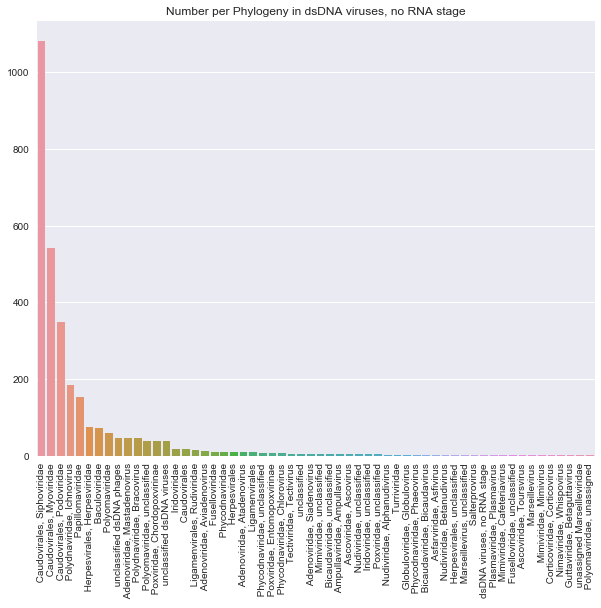

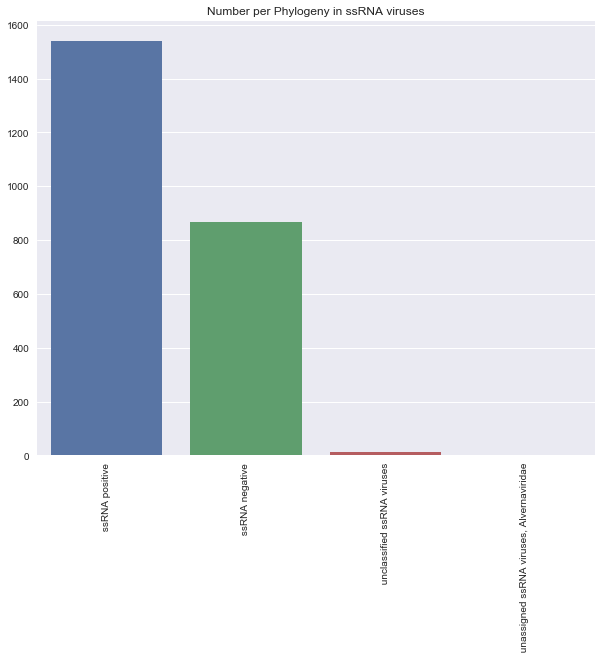

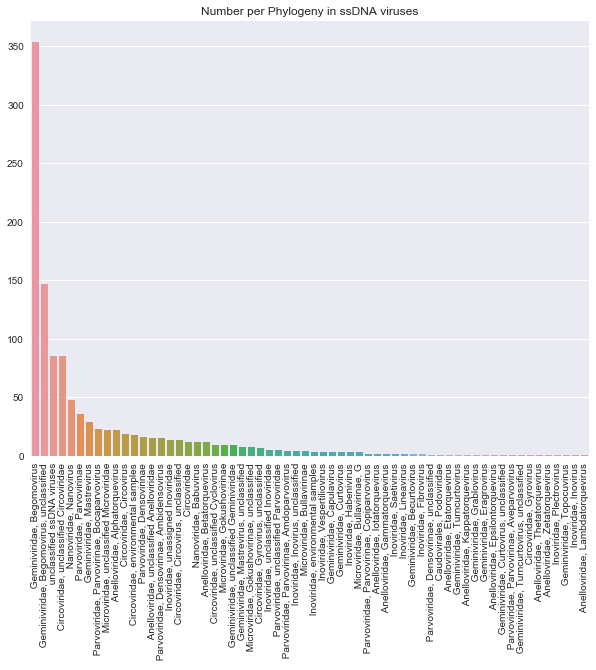

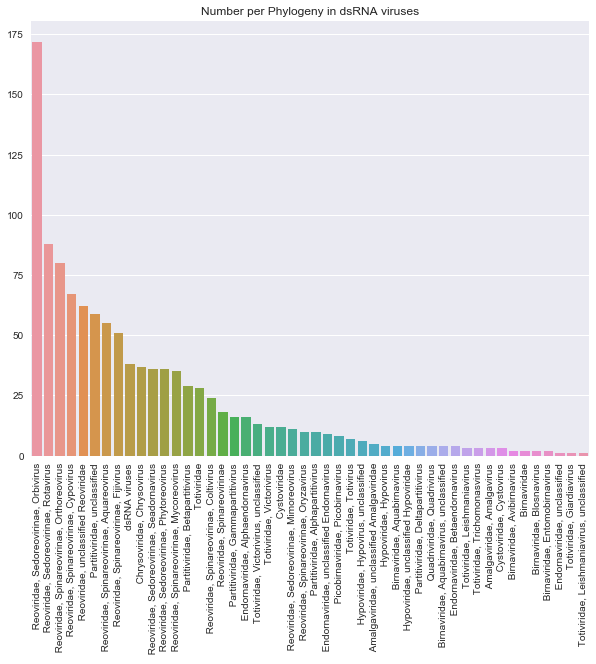

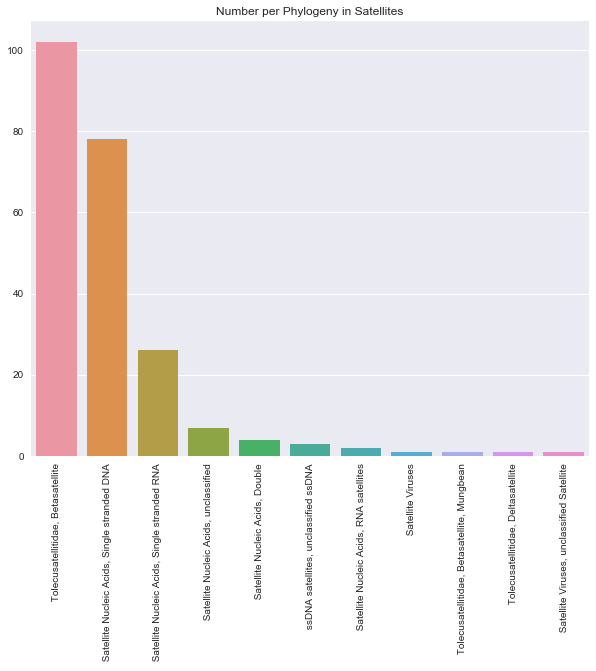

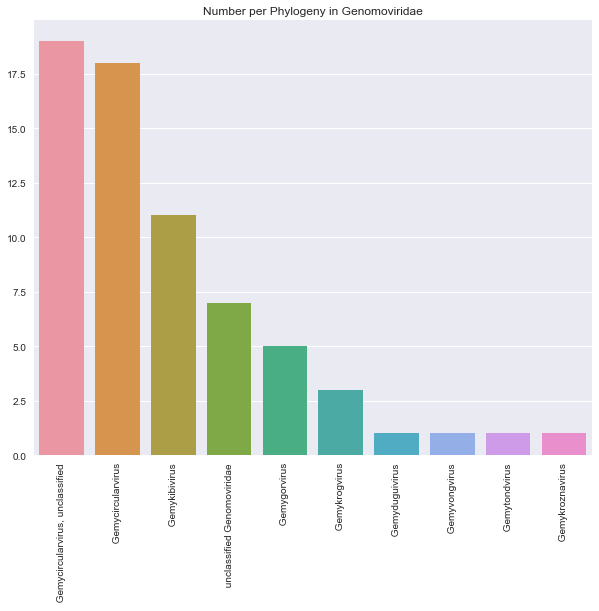

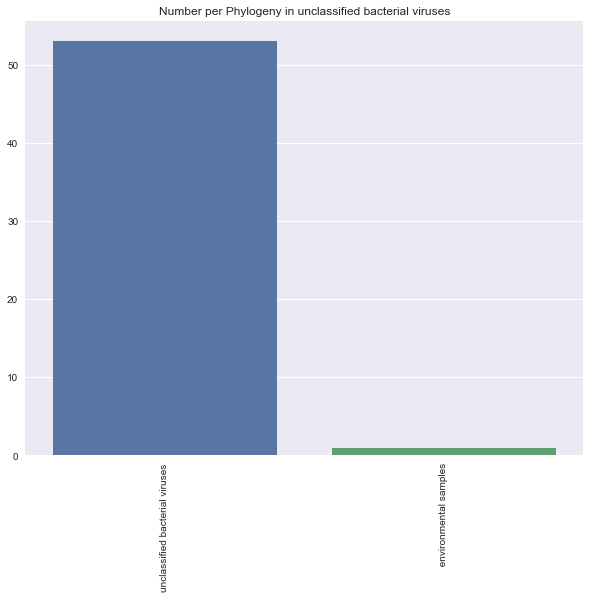

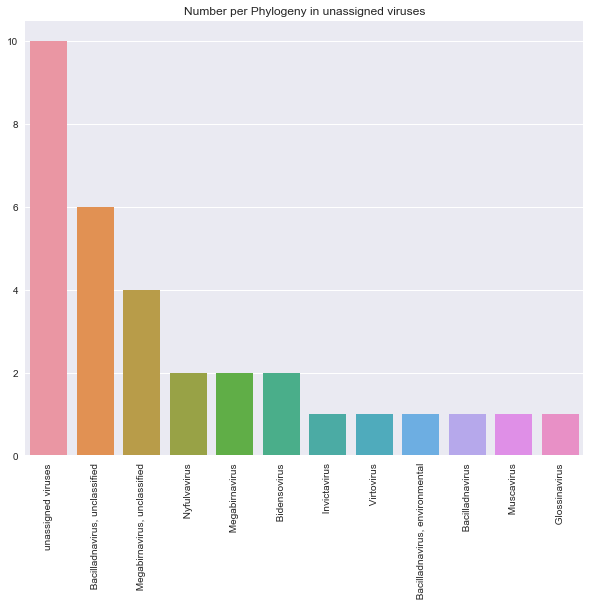

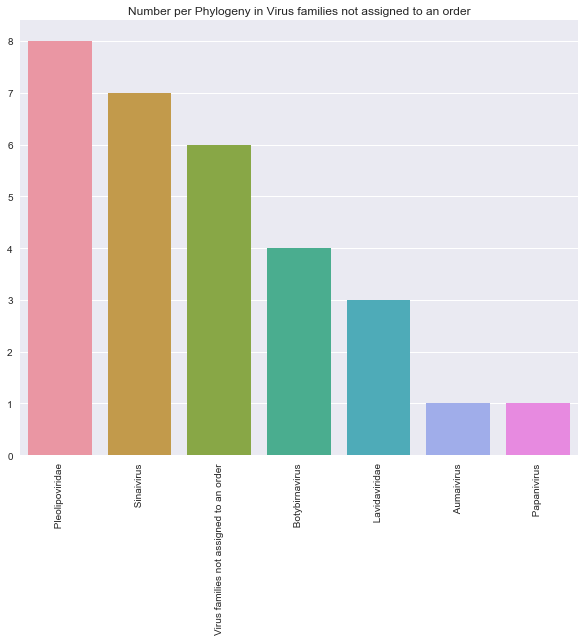

In [16]:
for classification in classifications:
    # For each classification, create a DataFrame with just that subset of the data, and create a list of 
    #  phylogenies and their respective counts 
    pd = genomes.loc[genomes['Classification'] == classification]
    phylogenies = [item[0] for item in list(pd['Phylogeny'].value_counts().items())]
    phylo_counts = [item[1] for item in list(pd['Phylogeny'].value_counts().items())]
    p_title = 'Number per Phylogeny in {}'.format(classification) 
    if len(phylogenies) > 1:
        # Plot phylogenies vs counts for each classification
        plt.figure(figsize = (10,8))
        phylo_count_bar = sns.barplot(phylogenies, phylo_counts)
        for item in phylo_count_bar.get_xticklabels():
            item.set_rotation(90)
        plt.title(p_title)
        None
    else: 
        # If there's only one count, print that, as opposed to a single bar on a barplot
        print(p_title, '\n', phylogenies,':', phylo_counts, '\n')

### Breaking up the dataset/Preprocessing

In [78]:
# This function takes a series of sequences and matches them in length to the longest with 0s
def pad_seq_series(series):
    maximum = 0
    # Identify the length of the longest sequence in the series
    for seq in series:
        if len(seq) > maximum:
            maximum = len(seq)

    # This subfunction adds as many 0s as necessary to a sequence to make it as long as the longest one
    def pad_seq(seq, max_length):
        num_padding = max_length - len(seq)
        new_seq = seq + (num_padding * '0')
        return(new_seq)
    
    # Apply the pad_seq function to each sequence in the series
    padded_series = series.apply(pad_seq, max_length = maximum)
    
    return(padded_series)

In [ ]:
# This function takes a series of sequences and returns an array of the encoded variables in that series
def encode_seq_series(series):
    
    def nt_numerical(nt): 
        # Return numerical variables for each nucleotide in the sequence
        #  See citation below for an explanation of these variables and alternatives
        if nt == 'a':
            return(-1.5)
        elif nt == 't':
            return(1.5)
        elif nt == 'c':
            return(0.5)
        elif nt == 'g':
            return(-0.5)
        else:
            return(nt)
    
    genome_list = []
    for seq in series:
        # For each sequence, turn the string into a list of characterss, apply the function above to each char, 
        #  and add the resulting list to the genome_list
        seq_list = list(seq)
        mapped_list = list(map(nt_numerical, seq_list))
        genome_list.append(mapped_list)
    
    return(np.array(genome_list))

## Encoding variables are from:
# Keung Kwan, Hon & Arniker, Swarna. (2009). Numerical representation of DNA sequences. 
# 307 - 310. 10.1109/EIT.2009.5189632. 

note: each virus classification's dataframe and associated variables/models below is numbered, but this numbering is arbitrary and corresponds to the order I worked through them in. This numbering avoids typos and titles that look too similar. 

#### dsDNA viruses with no RNA stage 

In [17]:
# dsDNA viruses with no RNA stage, which would make for a clunky dataframe name
# this dataframe will include only complete genomes
genomes_0 = genomes.loc[genomes['Classification'] == 'dsDNA viruses, no RNA stage'][['Name', 'Phylogeny', 'Sequence', 'SequenceType']].copy()
genomes_0 = genomes_0.loc[genomes['SequenceType'] == 'complete genome'][['Name', 'Phylogeny', 'Sequence']]

genomes_0['target'] = genomes_0['Phylogeny'].apply(lambda x: 1 if 'Siphoviridae' in x else 0)
genomes_0['target'].value_counts()

genomes_0.head()

,Name,Phylogeny,Sequence
476,Abalone herpesvirus Victoria/AUS/2009,"Herpesvirales, unclassified",actcgtatgaactttgactggtttttggggcgcgagagtttggttt...
477,Abalone shriveling syndrome-associated virus,unclassified dsDNA viruses,ctatttaactaatttagtattgtttgttgttttcggttgagtcaat...
478,Acanthamoeba polyphaga mimivirus,"Mimiviridae, Mimivirus",cgccgggggttgacggcggggctgggaaacccattgaaatttccgt...
479,Acanthamoeba polyphaga moumouvirus,"Mimiviridae, unclassified",gaataataataatttttatttatttttacgggttttattgtttcca...
480,Acanthocystis turfacea Chlorella virus 1,"Phycodnaviridae, Chlorovirus",ttgctctgtctgcttgcattttgaagatttgccattgtcccgacat...


In [ ]:
# Pad and encode the series of sequences
X0 = genomes_0['Sequence']
X0 = pad_seq_series(X0)
X0 = encode_seq_series(X0)
X0

In [21]:

y0 = genomes_0['target']

X0_train, X0_test, y0_train, y0_test = train_test_split(X0, y0, test_size = 0.33, stratify = y0)

X0_train = X0_train.values.reshape(X0_train.shape[0], 1, 1)
X0_test = X0_test.values.reshape(X0_test.shape[0], 1, 1)

#### ssDNA viruses

In [68]:
# Gather only the complete genomes for ssDNA viruses
genomes_1 = genomes.loc[genomes['Classification'] == 'ssDNA viruses'][['Name', 'Phylogeny', 'Sequence', 'SequenceType']].copy()
genomes_1 = genomes_1.loc[genomes['SequenceType'] == 'complete genome'][['Name', 'Phylogeny', 'Sequence']]

# Set a target variable: 1 if a virus is in the 'Geminiviridae' family, otherwise 0
genomes_1['target'] = genomes_1['Phylogeny'].apply(lambda x: 1 if 'Geminiviridae' in x else 0)
print(genomes_1['target'].value_counts())

genomes_1.head()

1    541
0    533
Name: target, dtype: int64


,Name,Phylogeny,Sequence,target
4528,Abaca bunchy top virus segment 1,"Nanoviridae, Babuvirus",ggggctggggcttattattacccccagccccggaacgggacatcac...,0
4529,Abaca bunchy top virus segment 2,"Nanoviridae, Babuvirus",ggcaggggggcttattattaccccccctgcccgggacgggacatca...,0
4530,Abaca bunchy top virus segment 3,"Nanoviridae, Babuvirus",agcaggggggcttattattaccccccctgctcggggcgggacattc...,0
4531,Abaca bunchy top virus segment 4,"Nanoviridae, Babuvirus",ggcaggggggcttattattaccccccctgcccgggacgggacattt...,0
4532,Abaca bunchy top virus segment 5,"Nanoviridae, Babuvirus",agcaggggggcttattattaccccccctgctgggacgggacatccg...,0


In [79]:
# Pad and encode the series of sequences
X1 = genomes_1['Sequence']
X1 = pad_seq_series(X1)
X1 = encode_seq_series(X1)
X1

array([['-0.5', '-0.5', '-0.5', ..., '0', '0', '0'],
       ['-0.5', '-0.5', '0.5', ..., '0', '0', '0'],
       ['-1.5', '-0.5', '0.5', ..., '0', '0', '0'],
       ..., 
       ['-1.5', '0.5', '0.5', ..., '0', '0', '0'],
       ['-1.5', '-1.5', '-1.5', ..., '0', '0', '0'],
       ['-1.5', '-1.5', '-0.5', ..., '0', '0', '0']], 
      dtype='<U32')

In [80]:
# Set up the target variable and train_test_split, with an equal proportion of target variables in test/train
y1 = to_categorical(genomes_1['target'])

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.33, stratify = y1)

# Reshape the input variables to make them 3D
X1_train = X1_train.reshape(X1_train.shape[0],1,len(X1[0]),1)
X1_test = X1_test.reshape(X1_test.shape[0],1,len(X1[0]),1)

# Check the shape
X1_train.shape

(719, 1, 11702, 1)

#### ssRNA viruses

In [69]:
# complete genomes for ssRNA viruses
genomes_2 = genomes.loc[genomes['Classification'] == 'ssRNA viruses'][['Name', 'Phylogeny', 'Sequence', 'SequenceType']].copy()
genomes_2 = genomes_2.loc[genomes['SequenceType'] == 'complete genome'][['Name', 'Phylogeny', 'Sequence']]

genomes_2['target'] = genomes_2['Phylogeny'].apply(lambda x: 1 if 'positive' in x else 0)
print(genomes_2['target'].value_counts())

genomes_2.head()

1    1289
0     557
Name: target, dtype: int64


,Name,Phylogeny,Sequence,target
5648,Achimota virus 1,ssRNA negative,accagagggaaaatataacaatgtcgttttatagcgatgtaaataa...,0
5649,Achimota virus 2,ssRNA negative,accagagggaaaattaagaaaggtcgttccaagacgacttaaaaga...,0
5650,Acinetobacter phage AP205,ssRNA positive,ggagtgaaccccggagggggttcgctgaaagccgaatcgaattcga...,1
5651,Aconitum latent virus,ssRNA positive,cgaaaaactgaacatacaatatcctgacatacacagaagtacacta...,1
5652,Actinidia virus 1,ssRNA positive,aaccataacggcaattatttcgcagatttcatttgctgttgtataa...,1


In [77]:
X2 = genomes_2['Sequence']
X2 = pad_seq_series(X2)
X2 = encode_seq_series(X2)
X2

array([[-1.5, 0.5, 0.5, ..., '0', '0', '0'],
       [-1.5, 0.5, 0.5, ..., '0', '0', '0'],
       [-0.5, -0.5, -1.5, ..., '0', '0', '0'],
       ..., 
       [-1.5, -1.5, -1.5, ..., '0', '0', '0'],
       [-1.5, -1.5, -1.5, ..., '0', '0', '0'],
       [-0.5, -1.5, -1.5, ..., '0', '0', '0']], dtype=object)

In [89]:
y2 = to_categorical(genomes_2['target'])

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.33, stratify = y2)

X2_train = X2_train.reshape(X2_train.shape[0],1,len(X2[0]),1)
X2_test = X2_test.reshape(X2_test.shape[0],1,len(X2[0]),1)

X2_train.shape

(1236, 1, 33452, 1)

# Convolutional Neural Nets

In [85]:
# CNN to classify ssDNA viruses (1)
model_1 = Sequential()
model_1.add(Conv2D(50, kernel_size =(1,100), input_shape=(1, 11702, 1), activation='relu'))
model_1.add(MaxPool2D((1, 5)))
model_1.add(Conv2D(40, (1,100), activation='relu'))
model_1.add(MaxPool2D((1, 4)))
model_1.add(Conv2D(30, (1,100), activation='relu'))
model_1.add(MaxPool2D((1, 3)))
model_1.add(Conv2D(20, (1,100), activation='relu'))
model_1.add(MaxPool2D((1, 2)))
model_1.add(Flatten())
model_1.add(Dense(50, activation='relu'))
model_1.add(Dense(y1.shape[1], activation='sigmoid'))

model_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_1.fit(X1_train, y1_train, validation_data = (X1_test, y1_test), epochs = 10)

plot_model(model_1, to_file='model_1.png')

Train on 719 samples, validate on 355 samples
Epoch 1/10
719/719 [==============================] - 63s 88ms/step - loss: 0.4422 - acc: 0.8192 - val_loss: 0.3966 - val_acc: 0.9183
Epoch 2/10
719/719 [==============================] - 63s 88ms/step - loss: 0.2452 - acc: 0.9221 - val_loss: 0.2222 - val_acc: 0.9155
Epoch 3/10
719/719 [==============================] - 63s 87ms/step - loss: 0.1840 - acc: 0.9249 - val_loss: 0.2236 - val_acc: 0.9183
Epoch 4/10
719/719 [==============================] - 62s 86ms/step - loss: 0.1686 - acc: 0.9305 - val_loss: 0.2488 - val_acc: 0.9155
Epoch 5/10
719/719 [==============================] - 63s 87ms/step - loss: 0.1683 - acc: 0.9249 - val_loss: 0.3090 - val_acc: 0.9239
Epoch 6/10
719/719 [==============================] - 63s 88ms/step - loss: 0.1677 - acc: 0.9346 - val_loss: 0.2051 - val_acc: 0.9239
Epoch 7/10
719/719 [==============================] - 64s 88ms/step - loss: 0.1371 - acc: 0.9430 - val_loss: 0.2053 - val_acc: 0.9352
Epoch 8/10
719/7

In [94]:
# CNN to classify ssRNA viruses (2)
model_2 = Sequential()
model_2.add(Conv2D(50, kernel_size =(1,100), input_shape=(X2_train.shape[1:]), activation='relu'))
model_2.add(MaxPool2D((1, 5)))
model_2.add(Conv2D(40, (1,100), activation='relu'))
model_2.add(MaxPool2D((1, 4)))
model_2.add(Conv2D(30, (1,100), activation='relu'))
model_2.add(MaxPool2D((1, 3)))
model_2.add(Conv2D(20, (1,100), activation='relu'))
model_2.add(MaxPool2D((1, 2)))
model_2.add(Flatten())
model_2.add(Dense(50, activation='relu'))
model_2.add(Dense(y2.shape[1], activation='sigmoid'))

model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model_2.fit(X2_train, y2_train, validation_data = (X2_test, y2_test), epochs = 10)

Train on 1236 samples, validate on 610 samples
Epoch 1/10
1236/1236 [==============================] - 307s 248ms/step - loss: 0.5734 - acc: 0.7031 - val_loss: 0.5213 - val_acc: 0.7770
Epoch 2/10
1236/1236 [==============================] - 304s 246ms/step - loss: 0.4938 - acc: 0.7387 - val_loss: 0.4452 - val_acc: 0.7754
Epoch 3/10
1236/1236 [==============================] - 304s 246ms/step - loss: 0.4657 - acc: 0.7362 - val_loss: 0.4561 - val_acc: 0.7869
Epoch 4/10
1236/1236 [==============================] - 315s 255ms/step - loss: 0.4530 - acc: 0.7500 - val_loss: 0.4371 - val_acc: 0.7344
Epoch 5/10
1236/1236 [==============================] - 302s 245ms/step - loss: 0.4337 - acc: 0.7581 - val_loss: 0.3954 - val_acc: 0.8131
Epoch 6/10
1236/1236 [==============================] - 322s 260ms/step - loss: 0.3809 - acc: 0.8147 - val_loss: 0.3492 - val_acc: 0.8279
Epoch 7/10
1236/1236 [==============================] - 312s 253ms/step - loss: 0.3368 - acc: 0.8398 - val_loss: 0.3789 - val